## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np

%cd ./06_data

/Users/darioliotta/Documents/Physics of Data/Laboratory of Computational Physics/Exercises/06_data


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [9]:
file = 'data_000637.txt'
data = pd.read_csv(file)                 #Reading the file

N_min = 10000                            #Minimum of rows
N_max = data.shape[0]                    #Maximum of rows
N = np.random.randint(N_min, N_max)      #Getting a random value in between

subdata = pd.read_csv(file, nrows = N)   #Loading again data, this time with only N rows
subdata                                  #Seeing the content of data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
839546,1,0,122,3869207934,808,19
839547,1,0,63,3869207934,808,29
839548,1,0,139,3869207934,811,0
839549,1,0,64,3869207934,811,20


2\. Find out the number of BX in a ORBIT (the value 'x').

Every ORBIT_CNT is increased every 'x' BX_COUNTER, so we just need to get the max value of BX_COUNTER that should be the same for every ORBIT_CNT

In [10]:
#We add 1 because the count goes from 0 to x-1 (for the same reason that the counting in seconds stops at 59 but one minute is composed by 60 seconds)
x = subdata['BX_COUNTER'].max() + 1
print(x)

3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [11]:
#Every x an ORBIT_CNT is performed, so we just need to convert it to nanoseconds
time_orbit = x * 25

#Then we just get the number of orbits in the datasheet
orbits_number = subdata['ORBIT_CNT'].max() - subdata['ORBIT_CNT'].min()

#So the time required to collect data is equal to the number of orbits times the time of a single orbit
time_of_measure = orbits_number * time_orbit

#Recall that we're working with a N/N_max fraction of the entire data, so we need to perform a proportion in order to get the real time
time_of_measure = time_of_measure * (N_max / N) * 10 ** (-9)
print(f"Estimated time: {time_of_measure} seconds")

#We can do the same calculation just with the entire data 
orbits_number = data['ORBIT_CNT'].max() - data['ORBIT_CNT'].min()
time_of_measure = orbits_number * time_orbit
time_of_measure = time_of_measure * 10 ** (-9)
print(f"Actual time: {time_of_measure} seconds")

Estimated time: 1.0804230780309951 seconds
Actual time: 0.9804564 seconds


So it took approximately one second to collect data.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [12]:
subdata['ABSOLUTE_TIME'] = pd.Series((data['ORBIT_CNT'] * x) + (data['BX_COUNTER'] * 25) + (data['TDC_MEAS'] * 25/30), index = subdata.index)
subdata

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,1.378983e+13
1,1,0,124,3869200167,2374,27,1.378983e+13
2,1,0,63,3869200167,2553,28,1.378983e+13
3,1,0,64,3869200167,2558,19,1.378983e+13
4,1,0,64,3869200167,2760,25,1.378983e+13
...,...,...,...,...,...,...,...
839546,1,0,122,3869207934,808,19,1.378986e+13
839547,1,0,63,3869207934,808,29,1.378986e+13
839548,1,0,139,3869207934,811,0,1.378986e+13
839549,1,0,64,3869207934,811,20,1.378986e+13


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [8]:
subdata['HEAD'] = np.random.choice([0, 1], size = len(subdata))
subdata

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,0,0,123,3869200167,2374,26,1.378983e+13
1,1,0,124,3869200167,2374,27,1.378983e+13
2,0,0,63,3869200167,2553,28,1.378983e+13
3,1,0,64,3869200167,2558,19,1.378983e+13
4,0,0,64,3869200167,2760,25,1.378983e+13
...,...,...,...,...,...,...,...
791167,0,0,61,3869207616,974,14,1.378986e+13
791168,1,1,42,3869207616,1267,6,1.378986e+13
791169,1,1,48,3869207616,1266,19,1.378986e+13
791170,0,1,46,3869207616,1270,10,1.378986e+13


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [9]:
newdata = subdata[subdata['HEAD'] == 1]
newdata

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
1,1,0,124,3869200167,2374,27,1.378983e+13
3,1,0,64,3869200167,2558,19,1.378983e+13
6,1,0,61,3869200167,2772,14,1.378983e+13
7,1,0,139,3869200167,2776,0,1.378983e+13
8,1,0,62,3869200167,2774,21,1.378983e+13
...,...,...,...,...,...,...,...
791163,1,0,47,3869207616,971,4,1.378986e+13
791164,1,0,63,3869207616,971,21,1.378986e+13
791165,1,0,45,3869207616,978,12,1.378986e+13
791168,1,1,42,3869207616,1267,6,1.378986e+13


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

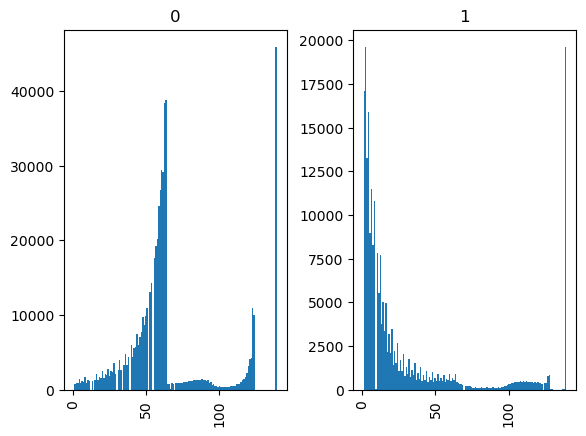

In [11]:
channels_number = subdata['TDC_CHANNEL'].max()
histogram = subdata.hist(column = 'TDC_CHANNEL', by = 'FPGA', bins = channels_number + 1)

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [12]:
#Creating a new column made just of 1
subdata['COUNTS'] = pd.Series(np.ones(len(subdata)).astype(int), index = subdata.index)

#Summing with respect to channels and sorting by decreasing channel counts
top = 3
subdata.groupby('TDC_CHANNEL')[['COUNTS']].sum().sort_values(by = 'COUNTS', ascending = False)[:top]

,COUNTS
TDC_CHANNEL,
139,65526
64,39636
63,38948


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [13]:
orbits_number = subdata.groupby('ORBIT_CNT').count().shape[0]
print(f"Unique number of orbits: {orbits_number}")

subdata_139 = subdata[subdata['TDC_CHANNEL'] == 139]
orbits_number_139 = subdata_139.groupby('ORBIT_CNT').count().shape[0]
print(f"Unique number of orbits with at least one measurement from channel 139: {orbits_number_139}")

Unique number of orbits: 7446
Unique number of orbits with at least one measurement from channel 139: 7421
